This notebook is used to generate the nearest text from the RSICD caption corpus of the CLIP-model for the LongFellow images

In [1]:
import os
wd = "./Sim/LongFellowCLipInterp/"
os.chdir(wd)
import sys
import logging 
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor, set_seed
from Utils import process_images, AvgGradientNorm
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import defaultdict

# Global Variables
REDOWNLOADDATA = False
monte_carlo_i = 1
Separate = False
Full=True
target_name = 'NOTobsY' # 'obsY', or 'tauPred'

# Path parameters
optimize_image_reps = "clip-rsicd"
data_type = "image"
applications = ["peru"]
perturbation_magnitude = 0
image_type = "original"
image_size1 = 64
image_size2 = 256
if sys.argv[1] == '-f':
    iter_num = -1
    print("Warning: Running in Jupyter Notebook. Using default value -1.")
elif len(sys.argv) > 1:
    args = sys.argv[1:]  # Get command line arguments
    iter_num = int(args[0])  # Assuming args is defined earlier in the code
    monte_carlo_i = int(args[1])
    if len(sys.argv) > 3:
        image_size1 = args[2]
        image_size2 = args[3]
else:
    iter_num = -1
    print("Warning: No iteration number provided. Using default value -1.")

# Directories
os.makedirs('./Figures', exist_ok=True)
os.makedirs('./TrainingInfo', exist_ok=True)
os.makedirs('./log', exist_ok=True)
os.makedirs('./FineTuneIterResults', exist_ok=True)
save_ImageTensor_dir = './DataInfo/Images'
saveObsWDir = './DataInfo/ObsW'
saveGeoDir = './DataInfo/geo'
saveObsYDir = './DataInfo/ObsY'
saveTrainIndicesDir = './DataInfo/TrainIndices'
saveResDir = './FineTuneIterResults/FineTuneRes'
saveRepDir = './FineTuneIterResults/FineTuneReps'

saveDirs = [saveObsWDir, saveGeoDir, saveObsYDir, save_ImageTensor_dir, saveTrainIndicesDir, saveResDir, saveResDir]
for dir in saveDirs:
    os.makedirs(dir, exist_ok=True)
    os.makedirs(dir, exist_ok=True)
logging.basicConfig(filename=f'./log/trainingIter_{iter_num}.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
def set_all_seeds(seed_value=42):
    # 1. Python's built-in random library
    random.seed(seed_value)
    
    # 2. NumPy's random seed
    np.random.seed(seed_value)
    
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
set_all_seeds(monte_carlo_i)

# Get CLIP model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP_model = CLIPModel.from_pretrained("flax-community/clip-rsicd-v2").to(device)
CLIP_processor = CLIPProcessor.from_pretrained("flax-community/clip-rsicd-v2")

2024-10-31 22:28:13.551602: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 22:28:13.563396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 22:28:13.576422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 22:28:13.580376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 22:28:13.591204: I tensorflow/core/platform/cpu_feature_guar

## Get Word List

In [29]:
# Get the word_set
import re
def clean_sentence(sentence):
    # Step 1: Remove extra spaces and correct common grammatical issues
    sentence = sentence.strip()  # Remove leading/trailing spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Replace multiple spaces with a single space
    
    # Step 2: Fix spacing around punctuation (remove space before period)
    sentence = re.sub(r'\s+\.', '.', sentence)
    
    # Step 3: Correct capitalization (capitalize the first letter of the sentence)
    sentence = sentence[0].upper() + sentence[1:]
    
    return sentence

def get_unique_words(sentence_list):
    # Step 1: Create an empty set to store unique words
    unique_words = set()
    
    # Step 2: Iterate through each sentence in the list
    for sentence in sentence_list:
        # Step 3: Convert sentence to lowercase and remove punctuation using regex
        sentence = re.sub(r'[^\w\s]', '', sentence.lower())
        
        # Step 4: Split sentence into words
        words = sentence.split()
        
        # Step 5: Add words to the set (automatically removes duplicates)
        unique_words.update(words)
    
    return unique_words

# Get the rsicd sentences
sentence_path = './rsicd_total_sentences.txt'

with open(sentence_path, 'r') as file:
    # Use strip to remove any extra spaces or newline characters
    sentence_list = list(set([line.strip() for line in file]))
    
# Define the land cover categories
land_cover_categories = [
    "Open Water",
    "Perennial Ice/Snow",
    "Developed, Open Space",
    "Developed, Low Intensity",
    "Developed, Medium Intensity",
    "Developed, High Intensity",
    "Barren Land (Rock/Sand/Clay)",
    "Deciduous Forest",
    "Evergreen Forest",
    "Mixed Forest",
    "Dwarf Scrub",
    "Shrub/Scrub",
    "Grassland/Herbaceous",
    "Sedge/Herbaceous",
    "Lichens",
    "Moss",
    "Pasture/Hay",
    "Cultivated Crops",
    "Woody Wetlands",
    "Emergent Herbaceous Wetlands"
]

# Post-process and store everything into match_lists
land_cover_sentences = ["An aerial photograph of " + category.lower() + " area." for category in land_cover_categories]
sentence_list = [sentence for sentence in sentence_list if "satellite" not in sentence]
sentence_list = [sentence[:-2] + "." if sentence[-2:] == " ." else sentence for sentence in sentence_list]
word_list = list(get_unique_words(sentence_list))
word_list = [re.sub(r'\d+', '', word) for word in word_list]
word_list = [item.replace("square_", "square") for item in word_list]
word_list = [word for word in word_list if len(word) > 2]
match_lists = [word_list, sentence_list, land_cover_sentences]
match_names = ["rsicd word", "rsicd sentence", "land_cover"]



# Find Embedding Similarity on Washington Picture

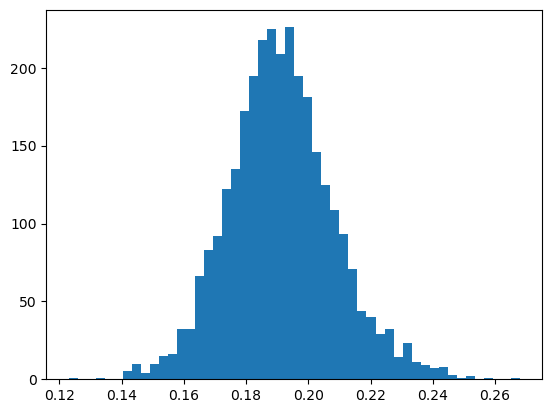

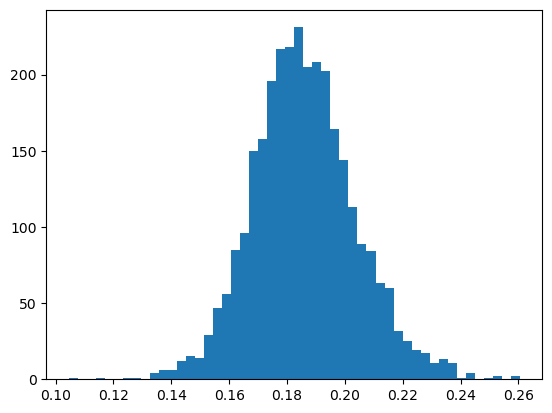

rsicd word's match for image_close is: viadu with similarity: 0.2679303288459778
rsicd word's match for image_far is: neighborhoods with similarity: 0.2604818046092987



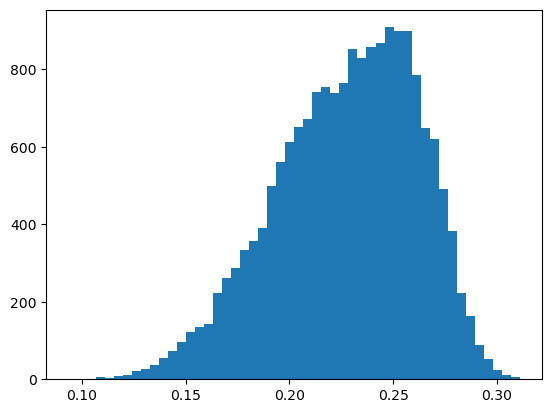

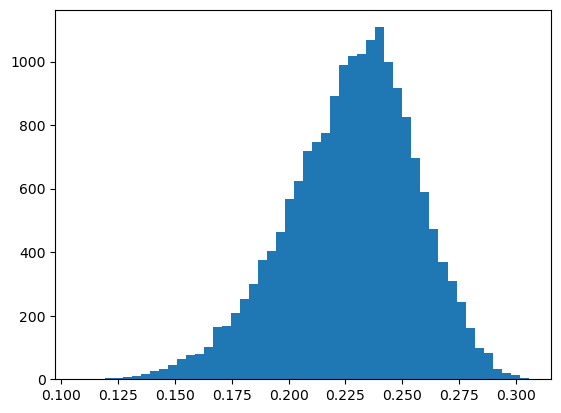

rsicd sentence's match for image_close is: the square with some halls and lawns is in a rectangular region shich is in the middle of the forest. with similarity: 0.3110278844833374
rsicd sentence's match for image_far is: here is a zone of apartment buildings between a river and a road. with similarity: 0.30567869544029236



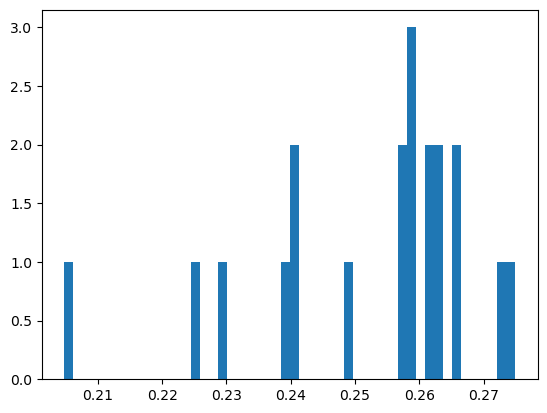

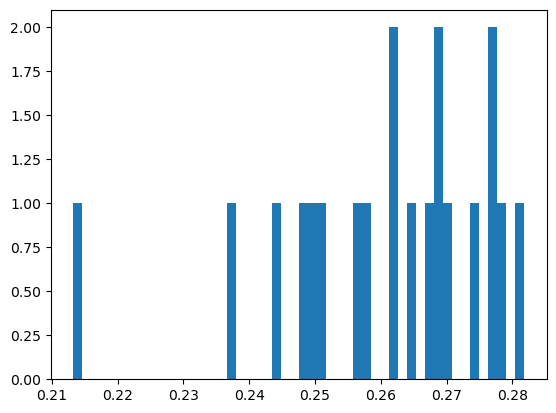

land_cover's match for image_close is: An aerial photograph of shrub/scrub area. with similarity: 0.27491849660873413
land_cover's match for image_far is: An aerial photograph of developed, low intensity area. with similarity: 0.28180885314941406



In [39]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
CLIP_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
CLIP_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load the two PNG images
image_close = Image.open('./Longfellow/longfellow_close.png')
image_far = Image.open('./Longfellow/longfellow_far.png')

# Ensure the images are loaded correctly
assert image_close is not None, "Failed to load longfellow_close.png"
assert image_far is not None, "Failed to load longfellow_far.png"

for i, match_list in enumerate(match_lists):
    name = match_names[i]
    batch_size = 100  # Adjust this based on available memory
    all_similarities_close = []
    all_similarities_far = []

    
    # Preprocess image inputs
    image_close_preprocessed = CLIP_processor(images=image_close, return_tensors="pt").to(device)
    image_far_preprocessed = CLIP_processor(images=image_far, return_tensors="pt").to(device)

    # Get text and image embeddings
    with torch.no_grad():
        # Get the image embeddings from the vision model
        image_close_embeddings = CLIP_model.get_image_features(**image_close_preprocessed)
        image_far_embeddings = CLIP_model.get_image_features(**image_far_preprocessed)
        
    image_close_embeddings = image_close_embeddings / image_close_embeddings.norm(dim=-1, keepdim=True)
    image_far_embeddings = image_far_embeddings / image_far_embeddings.norm(dim=-1, keepdim=True)
    
    for i in range(0, len(match_list), batch_size):
        # Preprocess a smaller batch of text inputs
        text_inputs = CLIP_processor(text=match_list[i:i+batch_size], return_tensors='pt', padding=True).to(device)
        input_ids = text_inputs['input_ids']
        attention_mask = text_inputs['attention_mask']

        # Get text embeddings for the smaller batch
        with torch.no_grad():
            text_embeddings = CLIP_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        # Normalize embeddings to get cosine similarity
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)


        # Compute cosine similarities between text and images
        similarities_close_batch = torch.matmul(text_embeddings, image_close_embeddings.T)
        similarities_far_batch = torch.matmul(text_embeddings, image_far_embeddings.T)
        
        # Append batch similarities to the total lists
        all_similarities_close.append(similarities_close_batch)
        all_similarities_far.append(similarities_far_batch)
    
    all_similarities_close = torch.cat(all_similarities_close, dim=0)
    all_similarities_far = torch.cat(all_similarities_far, dim=0)
    
    # Find the highest similarity for each image
    max_sim_close, best_match_close = all_similarities_close.max(dim=0)
    max_sim_far, best_match_far = all_similarities_far.max(dim=0)

    # Output the most similar text for each image
    print(f"{name}'s match for image_close is: {match_list[best_match_close.item()]} with similarity: {max_sim_close.item()}")
    print(f"{name}'s match for image_far is: {match_list[best_match_far.item()]} with similarity: {max_sim_far.item()}\n")